# Выбор локации для скважины

## Загрузка и подготовка данных

In [1]:
# Импорт библиотек.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from scipy import stats as st # для доверительного интервала

In [2]:
# Чтение файлов с данными и сохранение в датасеты.
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')

# Получение первых 5 строк датасетов
display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [3]:
# Получение общей информации о данных в датасетах
print(geo_data_0.info())
print(geo_data_1.info())
print(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory 

In [4]:
# Проверим на наличие явных дубликатов
print(geo_data_0.duplicated().sum())
print(geo_data_1.duplicated().sum())
print(geo_data_2.duplicated().sum())

0
0
0


In [5]:
# общие характеристики и проверка на наличие выбивающихся значений
display(geo_data_0.describe())
display(geo_data_1.describe())
display(geo_data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Согласно документации:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).
Пропуски и дубликаты в датасетах отсутствуют. Для всех датасетов средние значения близки к медианным, значит значительных выбросов в данных нет. Посмотрим корреляцию признаков.

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


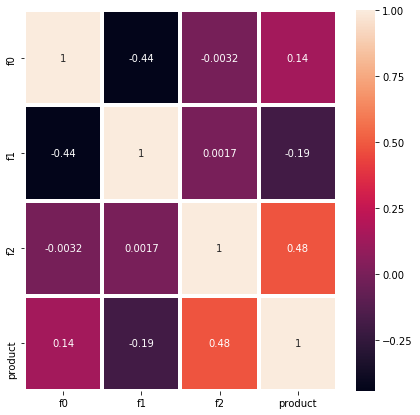

In [6]:
# оценка корреляций признаков
display(geo_data_0.corr())
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(geo_data_0.corr(), annot=True, linewidths=3, linecolor='white')

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


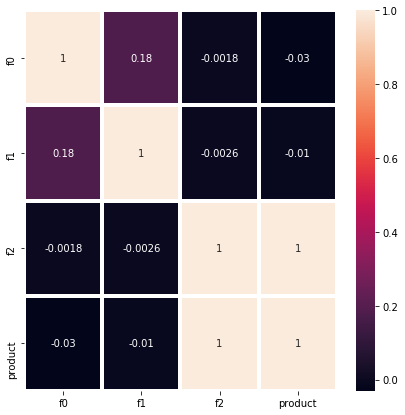

In [7]:
# оценка корреляций признаков
display(geo_data_1.corr())
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(geo_data_1.corr(), annot=True, linewidths=3, linecolor='white')

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


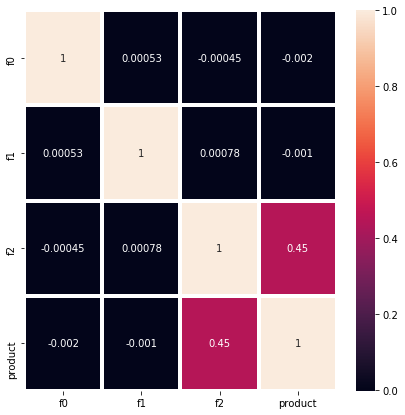

In [8]:
# оценка корреляций признаков
display(geo_data_2.corr())
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(geo_data_2.corr(), annot=True, linewidths=3, linecolor='white')

Корреляции между признаками практически нет. Однако для второго региона имеется прямая зависимость продукта от признака f2. Это означает, что объем нефти в данном регионе напрямую определяется признаком f2. 

Столбцы с id нам не нужны, удалим их из датасетов.

In [9]:
geo_data_0 = geo_data_0.drop('id', axis=1)
geo_data_1 = geo_data_1.drop('id', axis=1)
geo_data_2 = geo_data_2.drop('id', axis=1)

In [10]:
geo_data_0.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


Данные загружены и проанализированы, необходимости в серьезной обработке не выявлено. Из представленных выше статистик можно увидеть, что масштаб значений отличается, следовательно перед созданием модели потребуется их к единому масштабу.

## Обучение и проверка модели

Подготовим данные. Выделим признаки и целевой признак, разделим на обучающую и валидационную выборки в соотношении 3:1 и отмасштабируем.

In [11]:
# Создадим функцию разделения данных на обучающую и валидационную выборки
def split (geo_data_region):
    features = geo_data_region.drop('product', axis=1)
    target = geo_data_region['product']
    
    # Разделим выборки в пропорции 3:1
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.25, random_state=12345)
    # Приведем чесленные методы к одному масштабу
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid   

In [12]:
# Применим функцию и создадим обучающую и валидационную выборки для 3-х регионов
features_train_0, features_valid_0, target_train_0, target_valid_0 = split(geo_data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split(geo_data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split(geo_data_2)

# проверим работу функции на одном из регионов
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_l

In [13]:
# Проверим применение масштабирования
display(features_train_0.describe())
display(features_train_1.describe())
display(features_train_1.describe())

,f0,f1,f2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,1.704118e-16,-3.349025e-17,6.252776e-18
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.186288e+00,-2.178269e+00,-3.890945e+00
25%,-6.575544e-01,-8.925344e-01,-6.799576e-01
50%,1.878842e-03,-7.407961e-04,4.288679e-03
75%,6.571176e-01,8.928514e-01,6.829752e-01
max,2.139081e+00,2.169192e+00,4.153623e+00


,f0,f1,f2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,5.684342e-19,-1.028392e-16,-2.244131e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-3.652789e+00,-4.206546e+00,-1.476535e+00
25%,-8.290577e-01,-6.766541e-01,-8.784844e-01
50%,1.734177e-03,-1.083306e-03,-2.838957e-01
75%,8.349682e-01,6.768381e-01,8.834721e-01
max,3.154487e+00,4.588691e+00,1.482457e+00


,f0,f1,f2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,5.684342e-19,-1.028392e-16,-2.244131e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-3.652789e+00,-4.206546e+00,-1.476535e+00
25%,-8.290577e-01,-6.766541e-01,-8.784844e-01
50%,1.734177e-03,-1.083306e-03,-2.838957e-01
75%,8.349682e-01,6.768381e-01,8.834721e-01
max,3.154487e+00,4.588691e+00,1.482457e+00


In [14]:
# создаем функцию для получения предсказаний на модели LinearRegression()
def func(features_train, features_valid, target_train, target_valid):
    # инициализируем модель LinearRegression
    model = LinearRegression() 
    # обучим модель на обучающей выборке
    model.fit(features_train, target_train) 
    # получим предсказания модели на валидационной выборке
    predictions_valid = pd.Series(model.predict(features_valid)) 
    # считаем значение метрики RMSE на валидационной выборке
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    # расчитываем средний запас сырья 
    mean_stock = predictions_valid.mean()
    
    return predictions_valid, rmse, mean_stock

In [15]:
# получим данные для всех регионов
predictions_valid_0, rmse_0, mean_stock_0 = func(features_train_0, features_valid_0, target_train_0, target_valid_0)
predictions_valid_1, rmse_1, mean_stock_1 = func(features_train_1, features_valid_1, target_train_1, target_valid_1)
predictions_valid_2, rmse_2, mean_stock_2 = func(features_train_2, features_valid_2, target_train_2, target_valid_2)
print('Для региона 1 средний запас предсказанного сырья составил {:.2f}, а RMSE модели {:.2f}'.format(mean_stock_0, rmse_0))
print('Для региона 2 средний запас предсказанного сырья составил {:.2f}, а RMSE модели {:.2f}'.format(mean_stock_1, rmse_1))
print('Для региона 3 средний запас предсказанного сырья составил {:.2f}, а RMSE модели {:.2f}'.format(mean_stock_2, rmse_2))

Для региона 1 средний запас предсказанного сырья составил 92.59, а RMSE модели 37.58
Для региона 2 средний запас предсказанного сырья составил 68.73, а RMSE модели 0.89
Для региона 3 средний запас предсказанного сырья составил 94.97, а RMSE модели 40.03


Сравним правильность предсказаний модели и посмотрим на действительные средние запасы по каждому региону.

In [16]:
print('Для региона 1 истинный средний запас сырья равен {:.2f}'.format(target_valid_0.mean()))
print('Для региона 2 истинный средний запас сырья равен {:.2f}'.format(target_valid_1.mean()))
print('Для региона 3 истинный средний запас сырья равен {:.2f}'.format(target_valid_2.mean()))

Для региона 1 истинный средний запас сырья равен 92.08
Для региона 2 истинный средний запас сырья равен 68.72
Для региона 3 истинный средний запас сырья равен 94.88


Все 3 модели предсказывают значения, близкие к действительным, т.к. действительные средние запасы отличаются от предсказанных для каждой модели всего на несколько сотых.
Наилучшими прогнозными свойствами обладает модель 2, т.к. признак f2 имеет прямую зависимость с целевым признаком. Согласно показателям RMSE, предсказания моделидля 1 и 3 регионов примерно одинаковые.

## Подготовка к расчёту прибыли

### Создадим переменные с ключевыми показателями

In [17]:
# количество точек для исследования
count_points = 500
# количество точек для разработки
development_count = 200 
# бюджет на разработку скважин в регионе в млн. руб.
development_budget = 10000 
# доход с 1 тыс баррель в млн. руб
revenue_per_barrel = 0.45 
# максимальная вероятность убытков
losses_probability = 0.025 
# Bootstrap с 1000 выборок
bootstrap_samples = 1000

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Для этого необходимо:
- Вычислить допустимые затраты на разработку одной скважины.Разделим бюджет на количество скважин.
- Вычислить какое количество в тыс. баррель необходимо для покрытия затрат на одну скважину.

In [18]:
# Вычислим допустимые затраты на разработку одной скважины.
expenses = development_budget / development_count
print('Допустимые затраты на разработку одной скважины составляют', expenses, 'млн. руб.')

# Вычислим какое количество в тыс. баррель необходимо для покрытия затрат на одну скважину.
sufficient_volume = expenses / revenue_per_barrel
print('Необходимый объем сырья для безубыточной разработки 1 скважины в тыс. баррелей {:.2f}'.format(sufficient_volume))

Допустимые затраты на разработку одной скважины составляют 50.0 млн. руб.
Необходимый объем сырья для безубыточной разработки 1 скважины в тыс. баррелей 111.11


Необходимый достаточный объем сырья для того, чтобы разработка скважины была окупаемой, составил 111 тыс. баррелей. Средние значения запасов сырья для всех трех регионов ниже необходимого объема, что говорит о том, что при осуществлении разработки скважин, выбранных случайным образом, имеется высокая доля риска не окупить затраченный бюджет. Поэтому важно иметь модель, которая наиболее корректно предсказывала бы объем продукта в зависимости от известных факторов.

## Расчёт прибыли и рисков 

Проверим работоспособность созданных ранее моделей для определения скважин с максимальными значениями предсказаний. По условиям задачи при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Для выбранных скважин найдем соответствующие им истинные значения и по ним проведем расчет прибыли. Добавим все в функцию, чтобы не дублировать код для каждого региона.

### Расчет прибыли и рисков при исследовании всех точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [19]:
def calc_income(target_valid, predictions_valid):
    # выбирем 200 скважин с максимальным объемом нефти
    pred_max = predictions_valid.sort_values(ascending=False).head(200) 
    target_max = target_valid.reset_index(drop=True)[pred_max.index] 
    # определим доход в млн. рублей с 200 скважин
    income = target_max.sum() * revenue_per_barrel 
    return income

In [20]:
print('Прибыль с 200 выбранных лучших скважин по предсказаниям модели составит:')
print('для региона 1 - {:.3f} млн. руб.'.format(calc_income(target_valid_0, predictions_valid_0) - development_budget))
print('для региона 2 - {:.3f} млн. руб.'.format(calc_income(target_valid_1, predictions_valid_1) - development_budget))
print('для региона 3 - {:.3f} млн. руб.'.format(calc_income(target_valid_2, predictions_valid_2) - development_budget))

Прибыль с 200 выбранных лучших скважин по предсказаниям модели составит:
для региона 1 - 3320.826 млн. руб.
для региона 2 - 2415.087 млн. руб.
для региона 3 - 2710.350 млн. руб.


Мы получили прибыль с 200 выбранных лучших скважин для региона 1 - 3320.826 млн. руб., для региона 2 - 2415.087 млн. руб., для региона 3 - 2710.350 млн. руб. Однако такие результаты мы можем получить при условии того, что при разведке региона исследованы все точки, а по условиям задачи при разведке региона исследуют только 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Поэтому необходимо произвести расчет прибыли только по 500 точкам.

### Расчет прибыли и рисков при исследовании 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [21]:
# Создадим функцию для расчета выручки для 500 случайных скважин
def revenue (target_valid, predictions_valid, development_count):
    pred_max = predictions_valid.sort_values(ascending=False) # сортируем скважины по значениям их предсказаний
    
    # определяем верные значения для отобранных случайных скважин и берем только нужное количество
    target_max = target_valid[pred_max.index][:development_count]
    income = target_max.sum() * revenue_per_barrel # доход в млн. рублей
    return income

Далее определим распределение прибыли и убытков с помощью техники Bootstrap для 1000 выборок, в результате чего получим распределение выручек, из которых определим среднюю выручку для региона, доверительный интервал и вероятность получить отрицательную выручку.

In [26]:
# создадим функцию для применения для каждого региона
def income_distribution (predictions_valid, target_valid, bootstrap_samples, count_points):
    state = np.random.RandomState(12345)
    # Счетчик, который будет считать вероятность убытков в регионе
    count = 0 
    # Переменная, в которой будут храниться все значения выручек для 1000 выборок
    values = [] 
    # создаем 1000 выборок
    for i in range(bootstrap_samples): 
        # у целевого признака сбрасываем индексы и выбираем нужное количество скважин
        target_subsample = target_valid.reset_index(drop=True).sample(count_points, replace=True, random_state=state)
        
        # выбираем строки, соответствующие отобранным строкам в целевом признаке
        probs_subsample = predictions_valid[target_subsample.index]
        
        # считаем прибыль для отобранных строк, но только для нужного количества скважин
        rev = revenue(target_subsample, probs_subsample, development_count) - development_budget
        
        # добавляем прибыль в переменную values
        values.append(rev)
        
        # Если прибыль отрицательная, то увеличиваем счетчик
        if rev < 0:
            count += 1

    values = pd.Series(values)
    
    #посчитаем и выведем среднюю прибыль
    mean = values.mean()
    print("Средняя прибыль:", mean, 'млн рублей')
    
    lower = values.quantile(0.025)
    print('lower', lower)
    
    # посчитаем 95-% доверительный интервал
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), np.std(values, ddof=1) / np.sqrt(np.size(values)))
    print("95%-ый доверительный интервал:", confidence_interval)
    
    pvalue = 1. * count / bootstrap_samples
    if pvalue < losses_probability:
        print("Вероятность убытков равна {:.2%} и является меньше допустимой, регион подходит по критериям.".format(pvalue))
    else:
        print("Вероятность убытков равна {:.2%} и является больше допустимой, регион не подходит по критериям.".format(pvalue))    
    
    # построим распределение выручки по региону
    plt.figure()
    _ = plt.hist(values,  bins=100)
    
    # левая граница доверительного интервала
    one_x12, one_y12 = [confidence_interval[0], confidence_interval[0]], [0, 30]
    # правая граница доверительного интервала
    two_x12, two_y12 = [confidence_interval[1],confidence_interval[1]], [0, 30]
    plt.title('Гистограмма распределения прибыли')
    plt.xlabel('Прибыль в млн. рублей')
    plt.plot(one_x12, one_y12, two_x12, two_y12, marker = 'o')

Для первого региона при случайном выборе 500 скважин получаются следующие показатели:
Средняя прибыль: 425.9385269105927 млн рублей
lower -102.09009483793594
95%-ый доверительный интервал: (408.7322070686989, 443.1448467524865)
Вероятность убытков равна 6.00% и является больше допустимой, регион не подходит по критериям.


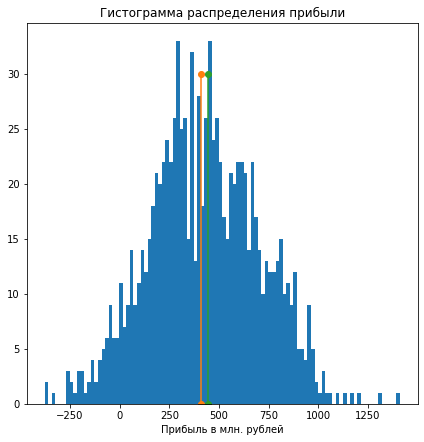

In [27]:
print('Для первого региона при случайном выборе 500 скважин получаются следующие показатели:') 
income_distribution(predictions_valid_0, target_valid_0, bootstrap_samples, count_points)

Для второго региона при случайном выборе 500 скважин получаются следующие показатели:
Средняя прибыль: 515.2227734432902 млн рублей
95%-ый доверительный интервал: (501.62147617632206, 528.8240707102583)
Вероятность убытков равна 1.00% и является меньше допустимой, регион подходит по критериям.


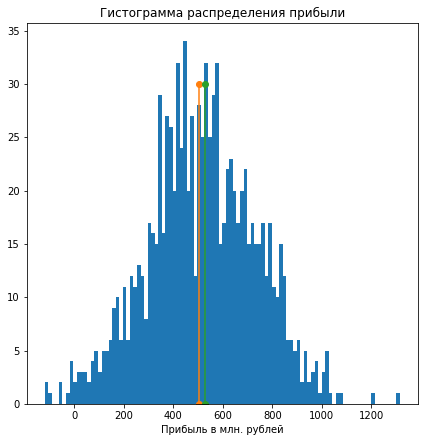

In [24]:
print('Для второго региона при случайном выборе 500 скважин получаются следующие показатели:') 
income_distribution(predictions_valid_1, target_valid_1, bootstrap_samples, count_points)

Для третьего региона при случайном выборе 500 скважин получаются следующие показатели:
Средняя прибыль: 435.00836278275585 млн рублей
95%-ый доверительный интервал: (417.4535520413581, 452.5631735241536)
Вероятность убытков равна 6.40% и является больше допустимой, регион не подходит по критериям.


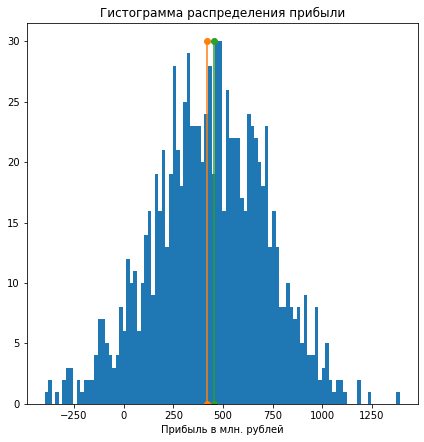

In [25]:
print('Для третьего региона при случайном выборе 500 скважин получаются следующие показатели:')
income_distribution(predictions_valid_2, target_valid_2, bootstrap_samples, count_points)

## Вывод

Проанализировав данные, можно сделать следующие выводы:
- прибыль с 200 выбранных лучших скважин для региона 1 - 3320.826 млн. руб., для региона 2 - 2415.087 млн. руб., для региона 3 - 2710.350 млн. руб. Однако такие результаты мы можем получить при условии того, что при разведке региона исследованы все точки, а по условиям задачи при разведке региона исследуют только 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- При случайном выборе 500 скважин для проведения разведки, потенциальная прибыль падает в среднем в 5-6 раз (1-й регион с 3.3 млрд рублей до 0.425 млрд рублей, 2-й регион с 2.4 млрд. до 0.515 млрд., 3-й регион с 2.7 млрд. до 0.435 млрд.) по сравнению с ситуацией, если бы мы проводили разведку для всего объема скважин, что повлекло бы увеличение зактрат;
- Согласно расчитанной средней прибыли, все регионы являются прибыльными, средняя прибыль составляет: 1-й регион 0.42 млрд рублей, 2-й регион, 0.51 млрд. рублей, 3-й регион 0.435 млрд. рублей;
- 1-ый и 3-й регионы обладают очень высокой вероятностью убытков (6 и 6.4 % соответственно), поэтому не проходят по условиям задачи (вероятность убытков должна быть меньше 2,5 %). Также эта ситуация хорошо описывается 95-% доврительным интервалом. Левая граница, которая отделяет 2.5 % данных для 1-го и 3-го регионов принимает отрицательное значение, что говорит о том, что более 2.5 % выборок имеют отрицательную прибыль;
- 2-й регион показал максимальные показатели. Он обладает наибольшей средней прибылью, а также единственный регион, который соответствует условию по минимальной вероятности убытков (левая граница 95-% доверительного интервала - положительная).  Поэтому  заказчику предлагается бурить скважины во 2-м регионе.